# Parts of Speech Sentiment Analysis Mini-Study
To further my interest in natural language processing using non-text/stylometric data, I created this mini-study with the purpose of showing that sentiment can be observed using only parts-of-speech tags for input. While there is a sizable amount of research dealing with POS and other stylometric data in authorship-attribution tasks, there is very little - if any - research into using solely POS/non-text stylometric data for other common NLP tasks, such as gauging user sentiment. I can't say why this is; maybe this whole thing is just so well-known that nobody is talking about it, or maybe it's the fact that POS and its related data types tend to be slightly less performant than traditional text input which fosters a lack of interest. Regardless, I have a hunch that POS tags generalized nature could make them useful as a strong base for transfer learning. This is an initial proof of concept to what will hopefully be part of a much larger experiment.

I've chosen to use sentiment140 as is somewhat of a NLP "Hello World!" dataset, similar to how MINST is to computer vision. It consists of 1.6 million tweets which have been labeled as either positive or negative. I've built of off Arun Pandian's "NLP Beginner - Text Classification using LSTM" on Kaggle because their kernel does most of what I want to study already and because of how thorough their comments are. I've modified the preprocessing to convert all text to POS tags using nltk. I swapped out the author’s Glove vectorizations for Word to Vec vectorizations. This is  because I won't be using transfer learning and because I've had better luck with W2V than Glove when starting from scratch in the past. The model itself has been modified significantly in order to better fit the new POS data. The key takeaways from the changes to the model are dropout, dropout, and a little more dropout, which the generalized POS embeddings appear to thrive under.

In all we scored 64% in overall accuracy, which isn't great considering random guessing would yield us 50%. The good news is that we've accomplished our goal of showing that POS tags alone do in fact convey sentiment. A slight drop in performance with POS is to be expected, and considering that the original model only got 78% using full text input with transfer learning, our results look a little bit better. I plan to graduate to a dataset with larger entries as twitter’s 140 character limit is likely contributing to the low scores across the board for this dataset on Kaggle. 

All comments below this line belong to the original author

## Natural Language Processing
**Natural Language Processing or NLP** is a branch of Artificial Intelligence which deal with bridging the machines understanding humans in their Natural Language. Natural Language can be in form of text or sound, which are used for humans to communicate each other. NLP can enable humans to communicate to machines in a natural way. 


**Text Classification** is a process involved in Sentiment Analysis. It is classification of peoples opinion or expressions into different sentiments. Sentiments include *Positive, Neutral*, and *Negative*, *Review Ratings* and *Happy, Sad*. Sentiment Analysis can be done on different consumer centered industries to analyse people's opinion on a particular product or subject. 

##  Importing Dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk

from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D, GlobalMaxPool1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from gensim.models import Word2Vec

import itertools
import random
import re
import os

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.8.0


#  Dataset Preprocessing
In this notebook, I am using **Sentiment-140** from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It contains a labels data of 1.6 Million Tweets and I find it a good amount of data to train our model.

In [2]:
df = pd.read_csv('tweets.csv', encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


You can see the columns are without any proper names. Lets rename them for our reference

In [3]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [4]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [5]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
    return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Here are decoding the labels. We map **0 -> Negative and 1 -> Positive** as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution. Because it's important that we have almost small amount of examples for given classes.

Text(0.5, 1.0, 'Sentiment Data Distribution')

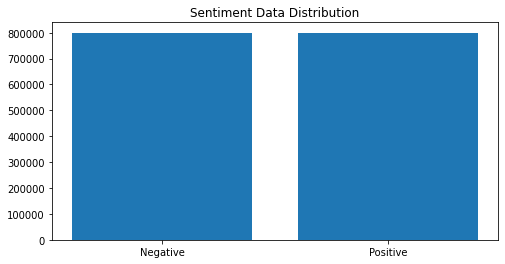

In [6]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness.

Now let us explore the data we having here... 

In [7]:
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
84260,Negative,Doesn't want to go to work right now
1402618,Positive,"@Traphik this: http://bit.ly/8DhRM , is HILARI..."
1599027,Positive,@twistedsunshine I see. But I don't want to sy...
670648,Negative,@anticlimatic I CAN'T CONNECT TO IT FOR SOME R...
1363208,Positive,"@scottsayare yes sir in fact, it's summer break!"
1147124,Positive,@awildberry how are u feeling?i dont feel so h...
1589797,Positive,"@FunkyChunks Yes, it's a good thing How are y..."
417501,Negative,I saw a guy that reminds me of a guy that I re...
504185,Negative,@Chriscorrell I am so jealous! I haven't had R...
707348,Negative,rt: Looks like Chicago was overlooked in the T...


Looks like we have a nasty data in text. Because in general we use lot of punctuations and other words without any contextual meaning. It have no value as feature to the model we are training. So we need to get rid of them.

# Text Preprocessing
Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods. Let's continue



### Hyperlinks and Mentions
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

- Twitter User Mentions - Eg. @arunrk7, @andrewng
- Hyperlinks - Eg. https://keras.io, https://tensorflow.org

**NLTK** is a python library which got functions to perform text processing task for NLP.

In [8]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    words = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(words)        
    pos = [tag[1] for tag in pos]
    pos = ' '.join(pos)
    return pos

In [10]:
if not os.path.exists('pos.csv'):
    df.text = df.text.apply(lambda x: preprocess(x))
    df.to_csv('pos.csv')
df = pd.read_csv('pos.csv')
df.text = df.text.astype(str)

## Train and Test Split

In [11]:
TRAIN_SIZE = 0.85
MAX_SEQUENCE_LENGTH = 30

In [12]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,random_state=2022)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1359999
Test Data size 240001


`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [13]:
train_data.head(10)

,Unnamed: 0,sentiment,text
975197,975197,Positive,NN DT NN RB PRP$ NN NNS RP DT NN CC DT NNS VBG...
1093428,1093428,Positive,VBG NN IN NN
1389857,1389857,Positive,WRB JJ
830173,830173,Positive,NN RB RB CD NNS IN NN CD IN CC RB RB JJ NN CD ...
105232,105232,Negative,NN VBP PRP RB
26109,26109,Negative,NN NN VBP DT NNS RB JJ WRB NN VBP DT NN NN NN ...
1382867,1382867,Positive,NN CD CD VBZ VBN JJ RB DT NN IN PRP RB VB NNS ...
350153,350153,Negative,NN NN VBP JJ VBD JJ NN IN RB IN RB RB CD JJ NN...
1452274,1452274,Positive,DT NN CC NN WRB JJ VBP VBN PRP
366595,366595,Negative,JJ NN NN VBD JJ VB RB RB JJ RB VB VBG WP VB VB...


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359999 entries, 975197 to 349053
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1359999 non-null  int64 
 1   sentiment   1359999 non-null  object
 2   text        1359999 non-null  object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


# Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization.**
![Tokenization](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/tokenization.png)

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`word_index` contains the index for each word

`vocab_size` represents the total number of word in the data corpus

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 37


Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from `pad_sequence` to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [16]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1359999, 30)
Testing X Shape: (240001, 30)


In [17]:
labels = train_data.sentiment.unique().tolist()

### Label Encoding 
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [18]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1359999, 1)
y_test shape: (240001, 1)


# Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it. 

**Word Embedding** is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

In [19]:
def word_vector(model, tokens, dim):
    """ 
    Generate a word vector.
    model: a completed model
    tokens: a list of words (in this case POS)
    dim: Number of dimensions. 100 - 300 is good for w2v
    """
    
    i = 0
    vec = np.zeros(dim).reshape((1, dim))
    for word in tokens:
        vec += model[word].reshape((1, dim))
        i += 1.
    if i != 0:
        vec /= i
    return vec

In [20]:
DIM = 300
pos = df.text
w2v_sg_model = Word2Vec(sentences=pos, vector_size=DIM, workers=18, seed=2022)

embedding_matrix = np.zeros((vocab_size, DIM)) 
for i in range(vocab_size):
    embedding_matrix[i,:] = word_vector(w2v_sg_model.wv, pos.iloc[i], DIM)

In [21]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

BATCH_SIZEretrained_embedding_layer(word_to_vec_map, word_to_index, max_le# Model Training - LSTM
We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use **Sequence Models**.

### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction. 

For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

3) **Dense** - Fully Connected Layers for classification


In [22]:
model = Sequential([
    embedding_layer,
    Dropout(rate=0.5),
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(rate=0.5),
    Bidirectional(LSTM(units=128, return_sequences=False)),
    Dense(units=1, activation='sigmoid')
])

### Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

### Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch.

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

Let's start training... It takes a heck of a time if training in CPU, be sure your GPU turned on... May the CUDA Cores be with you....

In [24]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [25]:
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
10625/10625 [==============================] - 167s 15ms/step - loss: 0.6722 - accuracy: 0.5778 - val_loss: 0.6554 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 2/10
10625/10625 [==============================] - 159s 15ms/step - loss: 0.6501 - accuracy: 0.6159 - val_loss: 0.6409 - val_accuracy: 0.6271 - lr: 0.0010
Epoch 3/10
10625/10625 [==============================] - 159s 15ms/step - loss: 0.6424 - accuracy: 0.6248 - val_loss: 0.6353 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 4/10
10625/10625 [==============================] - 159s 15ms/step - loss: 0.6382 - accuracy: 0.6299 - val_loss: 0.6327 - val_accuracy: 0.6371 - lr: 0.0010
Epoch 5/10
10625/10625 [==============================] - 160s 15ms/step - loss: 0.6353 - accuracy: 0.6331 - val_loss: 0.6313 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 6/10
10625/10625 [==============================] - 159s 15ms/step - loss: 0.6331 - accuracy: 0.6357 - val_loss: 0.6298 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 7/10
10625/10625 [====

# Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

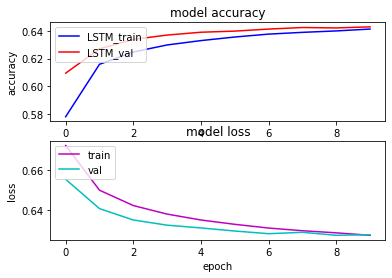

In [26]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

In [27]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

25/25 [==============================] - 2s 42ms/step


### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [28]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

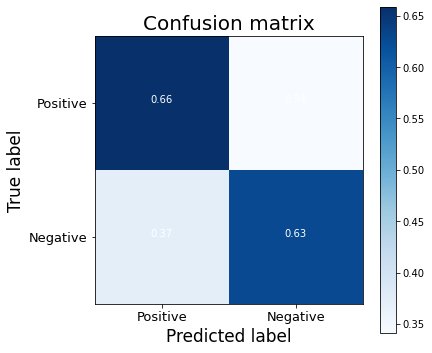

In [29]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [30]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.64      0.66      0.65    119960
    Positive       0.65      0.63      0.64    120041

    accuracy                           0.64    240001
   macro avg       0.64      0.64      0.64    240001
weighted avg       0.64      0.64      0.64    240001

